In [ ]:
import noise_calc
import prop_simulate
import prop_design
import optimization_NSGA2
# import xfoil_interface
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import pandas as pd

In [ ]:
Diameter_m = 3;
SpinnerCutoff = 0.2
NumberOfBlades = 2
ObjectiveThrust_N = 4000
AxialVelocity_m_s = 0
ForwardVelocity_m_s = 0
# ClPolars = pd.read_table("ClarkYAutoClPolar4.dat")
# CdPolars = pd.read_table("ClarkYAutoCdPolar4.dat")
ClMachPolars = pd.read_csv("ClarkYClPolar.dat", header = 1)
CdMachPolars = pd.read_csv("ClarkYCdPolar.dat", header = 1)
NumberOfStations = 11
Convergence = 0.001 #Newton

DistanceToObserver_m = 150
AngleToObserver_deg = 30    #Angle from Negative thrust to observer

SoundSpeed_m_s = 343
AirDensity_Kg_m3 = 1.225

In [ ]:
def Evaluation(Chromossome):

    Croot_adim = Chromossome["Croot"]
    Cmax_adim = Chromossome["Cmax"]
    Smax_adim = Chromossome["Smax"]
    Ctip_adim = Chromossome["Ctip"]
    Pitch_m = Chromossome["Pitch"]
    Colective_deg = Chromossome["Collective"]

    #c_R = (a*r**3 + b*r**2 + c*r + d)**0.5
    a = -(2*Cmax_adim**2*Smax_adim - Cmax_adim**2 + Croot_adim**2*Smax_adim**2 - 2*Croot_adim**2*Smax_adim + Croot_adim**2 - Ctip_adim**2*Smax_adim**2)/(Smax_adim**2*(Smax_adim - 1)**2)
    b = -(- 3*Cmax_adim**2*Smax_adim**2 + Cmax_adim**2 - 2*Croot_adim**2*Smax_adim**3 + 3*Croot_adim**2*Smax_adim**2 - Croot_adim**2 + 2*Ctip_adim**2*Smax_adim**3)/(Smax_adim**2*(Smax_adim - 1)**2)
    c = -(3*Cmax_adim**2*Smax_adim - 2*Cmax_adim**2 + Croot_adim**2*Smax_adim**3 - 3*Croot_adim**2*Smax_adim + 2*Croot_adim**2 - Ctip_adim**2*Smax_adim**3)/(Smax_adim*(Smax_adim - 1)**2)
    d = Croot_adim**2

    S = np.linspace(0, 0.9999, NumberOfStations, endpoint = True)
    RadialStations_adim = [SpinnerCutoff + ((1 - SpinnerCutoff)*s) for s in S]
    RadialStations_m = [r*Diameter_m/2 for r in RadialStations_adim]

    ChordDistribution_m = [((a*s**3 + b*s**2 + c*s + d)**0.5)*Diameter_m/2 for s in S]

    TwistDistribution_deg = prop_design.simple_pitch(RadialStations_m, Pitch_m)
    TwistDistributionCollective_deg = [twist + Colective_deg for twist in TwistDistribution_deg]

    
    
    UpperOmega_rad_s = 1000
    LowerOmega_rad_s = 10

    dT_vector, dQ_vector, r_vector, Re_vector, WA_vector, Cl_vector, Cd_vector = prop_simulate.qprop_PrePolarsPreDataframeWithMach(AxialVelocity_m_s, UpperOmega_rad_s, NumberOfBlades, Diameter_m/2, RadialStations_m, TwistDistributionCollective_deg, ChordDistribution_m, ClMachPolars, CdMachPolars)
    UpperResidue = ObjectiveThrust_N - np.trapz(dT_vector, r_vector)
    dT_vector, dQ_vector, r_vector, Re_vector, WA_vector, Cl_vector, Cd_vector = prop_simulate.qprop_PrePolarsPreDataframeWithMach(AxialVelocity_m_s, LowerOmega_rad_s, NumberOfBlades, Diameter_m/2, RadialStations_m, TwistDistributionCollective_deg, ChordDistribution_m, ClMachPolars, CdMachPolars)
    LowerResidue = ObjectiveThrust_N - np.trapz(dT_vector, r_vector)

    # CurrentOmega_rad_s = 200
    Converged = False
    for _ in range(100):

        MidOmega_rad_s = (UpperOmega_rad_s + LowerOmega_rad_s)/2
        # print(MidOmega_rad_s)
        dT_vector, dQ_vector, r_vector, Re_vector, WA_vector, Cl_vector, Cd_vector = prop_simulate.qprop_PrePolarsPreDataframeWithMach(AxialVelocity_m_s, MidOmega_rad_s, NumberOfBlades, Diameter_m/2, RadialStations_m, TwistDistributionCollective_deg, ChordDistribution_m, ClMachPolars, CdMachPolars)
        MidResidue = ObjectiveThrust_N - np.trapz(dT_vector, r_vector)

        if abs(MidResidue) < Convergence:
            Converged = True
            # print("===================================================================================================")
            break

        if UpperResidue*MidResidue < 0:
            LowerResidue = MidResidue
            LowerOmega_rad_s = MidOmega_rad_s
        elif LowerResidue*MidResidue < 0:
            UpperResidue = MidResidue
            UpperOmega_rad_s = MidOmega_rad_s
        else:
            print("Convergence Failed")
            break
    
    if not Converged:
        return [10**10, 200], {}
    
    SoundBand = noise_calc.OneThirdSpectrum()
    BladeArea_m2 = np.trapz(ChordDistribution_m, RadialStations_m)
    AverageBladeCl = sum(Cl_vector)/len(Cl_vector)
    TotalThrust_N = np.trapz(dT_vector, r_vector)
    TotalTorque_Nm = np.trapz(dQ_vector, r_vector)
    ThrustCoefficient = TotalThrust_N/(AirDensity_Kg_m3*((MidOmega_rad_s/(2*np.pi))**2)*(Diameter_m**4))
    TipSpeed_m_s = MidOmega_rad_s*Diameter_m/2

    Bands1_Hz, SPL1_dB = noise_calc.BroadbandNoise(BladeArea_m2, AverageBladeCl, TotalThrust_N, TipSpeed_m_s, DistanceToObserver_m, AngleToObserver_deg)
    Bands2_Hz, SPL2_dB = noise_calc.RotationalNoiseSteadyUnsteadyLoading(NumberOfBlades, ForwardVelocity_m_s/SoundSpeed_m_s, (MidOmega_rad_s*Diameter_m/2)/SoundSpeed_m_s, MidOmega_rad_s/(2*np.pi), DistanceToObserver_m, Diameter_m/2, noise_calc.CalculateRotorEffectiveRadius(ThrustCoefficient, Diameter_m/2), TotalThrust_N, 90 - AngleToObserver_deg, 0)
    # print(Bands2_Hz)
    # print(SPL2_dB)
    SoundBand.SumToSpectrum(Bands1_Hz, SPL1_dB)
    SoundBand.SumToSpectrum(Bands2_Hz, SPL2_dB)
    # print("Individual done!")

    return [TotalTorque_Nm*MidOmega_rad_s, SoundBand.PNLT()], {"TipSpeed_m_s": TipSpeed_m_s, "BladeArea_m2": BladeArea_m2, "AverageBladeCl": AverageBladeCl, "ThrustCoefficient": ThrustCoefficient, "RPM": MidOmega_rad_s*60/(2*np.pi)}

def Validation(Chromossome):
    
    Croot_adim = Chromossome["Croot"]
    Cmax_adim = Chromossome["Cmax"]
    Smax_adim = Chromossome["Smax"]
    Ctip_adim = Chromossome["Ctip"]
    Pitch_m = Chromossome["Pitch"]
    Colective_deg = Chromossome["Collective"]

    #c_R = (a*r**3 + b*r**2 + c*r + d)**0.5
    a = -(2*Cmax_adim**2*Smax_adim - Cmax_adim**2 + Croot_adim**2*Smax_adim**2 - 2*Croot_adim**2*Smax_adim + Croot_adim**2 - Ctip_adim**2*Smax_adim**2)/(Smax_adim**2*(Smax_adim - 1)**2)
    b = -(- 3*Cmax_adim**2*Smax_adim**2 + Cmax_adim**2 - 2*Croot_adim**2*Smax_adim**3 + 3*Croot_adim**2*Smax_adim**2 - Croot_adim**2 + 2*Ctip_adim**2*Smax_adim**3)/(Smax_adim**2*(Smax_adim - 1)**2)
    c = -(3*Cmax_adim**2*Smax_adim - 2*Cmax_adim**2 + Croot_adim**2*Smax_adim**3 - 3*Croot_adim**2*Smax_adim + 2*Croot_adim**2 - Ctip_adim**2*Smax_adim**3)/(Smax_adim*(Smax_adim - 1)**2)
    d = Croot_adim**2

    DerivativeZero = c/(2*(d**0.5))
    # print("Individual done validating!")
    if DerivativeZero < 0:
        return False
    DerivativeOne = (3*a + 2*b + c)/(2*((a + b + c + d)**0.5))
    if DerivativeOne > 0:
        return False
    return True

In [ ]:
import dill 

NInd = 100
DecimalPoints = 4
Convergence = 5
MovingAverageLen = 1
MovingAverageTol = 0.0001

for Try in [1, 2, 3, 4, 5]:
    RunNumber = 1
    for MutRate in [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]:
        for TSize in [1, 2, 5, 10, 25, 50]:
            OptimizationObject = optimization_NSGA2.NSGA2_v2(n_ind = NInd, mut_rate = MutRate, t_size = TSize, DecimalPoints = DecimalPoints, convergence = Convergence, ma_len = MovingAverageLen, ma_tol = MovingAverageTol)
            OptimizationObject.set_functions(Evaluation, Validation)
            OptimizationObject.set_population_limits({"Croot": [0.02, 0.3], "Cmax": [0.02, 0.4], "Smax": [0.0001, 0.9999], "Ctip": [0.02, 0.4], "Pitch": [0.1*Diameter_m, 2*Diameter_m], "Collective": [0, 30]})
            OptimizationObject.run()
            dill.dump_session(f"RUN{RunNumber}_{Try}.pkl")
            RunNumber += 1

In [ ]:
MinOASPL = math.inf
MinPower = math.inf
i = 0
for individual in optimization_NSGA2.return_pareto_front(OptimizationObject.current_pop):
    funcs = individual.get_ObjVal()
    if funcs[0] < MinPower:
        MinPower = funcs[0]
        MinPowerIndividual = individual
    if funcs[1] < MinOASPL:
        MinOASPL = funcs[1]
        MinOASPLIndividual = individual
    plt.plot(funcs[0], funcs[1], 'bo')
    i += 1
print(i)
plt.show()

In [ ]:
S = np.linspace(0, 1, NumberOfStations, endpoint = True)

Chromossome = MinOASPLIndividual.get_chrom()
Croot_adim = Chromossome["Croot"]
Cmax_adim = Chromossome["Cmax"]
Smax_adim = Chromossome["Smax"]
Ctip_adim = Chromossome["Ctip"]
Pitch_m = Chromossome["Pitch"]
Colective_deg = Chromossome["Collective"]
#c_R = (a*r**3 + b*r**2 + c*r + d)**0.5
a = -(2*Cmax_adim**2*Smax_adim - Cmax_adim**2 + Croot_adim**2*Smax_adim**2 - 2*Croot_adim**2*Smax_adim + Croot_adim**2 - Ctip_adim**2*Smax_adim**2)/(Smax_adim**2*(Smax_adim - 1)**2)
b = -(- 3*Cmax_adim**2*Smax_adim**2 + Cmax_adim**2 - 2*Croot_adim**2*Smax_adim**3 + 3*Croot_adim**2*Smax_adim**2 - Croot_adim**2 + 2*Ctip_adim**2*Smax_adim**3)/(Smax_adim**2*(Smax_adim - 1)**2)
c = -(3*Cmax_adim**2*Smax_adim - 2*Cmax_adim**2 + Croot_adim**2*Smax_adim**3 - 3*Croot_adim**2*Smax_adim + 2*Croot_adim**2 - Ctip_adim**2*Smax_adim**3)/(Smax_adim*(Smax_adim - 1)**2)
d = Croot_adim**2
plt.plot(S, [(a*s**3 + b*s**2 + c*s + d)**0.5 for s in S], label = "Minimum Noise")
print(f'Pitch: {Pitch_m}\nCollective: {Colective_deg}')

Chromossome = MinPowerIndividual.get_chrom()
Croot_adim = Chromossome["Croot"]
Cmax_adim = Chromossome["Cmax"]
Smax_adim = Chromossome["Smax"]
Ctip_adim = Chromossome["Ctip"]
Pitch_m = Chromossome["Pitch"]
Colective_deg = Chromossome["Collective"]
#c_R = (a*r**3 + b*r**2 + c*r + d)**0.5
a = -(2*Cmax_adim**2*Smax_adim - Cmax_adim**2 + Croot_adim**2*Smax_adim**2 - 2*Croot_adim**2*Smax_adim + Croot_adim**2 - Ctip_adim**2*Smax_adim**2)/(Smax_adim**2*(Smax_adim - 1)**2)
b = -(- 3*Cmax_adim**2*Smax_adim**2 + Cmax_adim**2 - 2*Croot_adim**2*Smax_adim**3 + 3*Croot_adim**2*Smax_adim**2 - Croot_adim**2 + 2*Ctip_adim**2*Smax_adim**3)/(Smax_adim**2*(Smax_adim - 1)**2)
c = -(3*Cmax_adim**2*Smax_adim - 2*Cmax_adim**2 + Croot_adim**2*Smax_adim**3 - 3*Croot_adim**2*Smax_adim + 2*Croot_adim**2 - Ctip_adim**2*Smax_adim**3)/(Smax_adim*(Smax_adim - 1)**2)
d = Croot_adim**2
plt.plot(S, [(a*s**3 + b*s**2 + c*s + d)**0.5 for s in S], label = "Minimum Power")
print(f'Pitch: {Pitch_m}\nCollective: {Colective_deg}')
plt.legend()
plt.show()

In [ ]:
for individual in optimization_NSGA2.return_pareto_front(OptimizationObject.current_pop):
    Chromossome = individual.get_chrom()
    Croot_adim = Chromossome["Croot"]
    Cmax_adim = Chromossome["Cmax"]
    Smax_adim = Chromossome["Smax"]
    Ctip_adim = Chromossome["Ctip"]
    Pitch_m = Chromossome["Pitch"]
    Colective_deg = Chromossome["Collective"]
    #c_R = (a*r**3 + b*r**2 + c*r + d)**0.5
    a = -(2*Cmax_adim**2*Smax_adim - Cmax_adim**2 + Croot_adim**2*Smax_adim**2 - 2*Croot_adim**2*Smax_adim + Croot_adim**2 - Ctip_adim**2*Smax_adim**2)/(Smax_adim**2*(Smax_adim - 1)**2)
    b = -(- 3*Cmax_adim**2*Smax_adim**2 + Cmax_adim**2 - 2*Croot_adim**2*Smax_adim**3 + 3*Croot_adim**2*Smax_adim**2 - Croot_adim**2 + 2*Ctip_adim**2*Smax_adim**3)/(Smax_adim**2*(Smax_adim - 1)**2)
    c = -(3*Cmax_adim**2*Smax_adim - 2*Cmax_adim**2 + Croot_adim**2*Smax_adim**3 - 3*Croot_adim**2*Smax_adim + 2*Croot_adim**2 - Ctip_adim**2*Smax_adim**3)/(Smax_adim*(Smax_adim - 1)**2)
    d = Croot_adim**2
    plt.plot(S, [(a*s**3 + b*s**2 + c*s + d)**0.5 for s in S])
plt.show()

In [ ]:
import dill 
#n_ind = 100, mut_rate = 0.05, t_size = 10, DecimalPoints = 4, convergence = 5, ma_len = 1, ma_tol = 0.0001
dill.dump_session("n_ind100 mut_rate0_05 t_size5 DecimalPoints4 convergence5 ma_len1 ma_tol0_0001 4 Generations20.pkl")
# dill.load_session("080720230023Session.pkl")

In [ ]:
BuggedChrom = {'Croot': 0.1333, 'Cmax': 0.3746, 'Smax': 0.5165, 'Ctip': 0.2501, 'Pitch': 5.1162, 'Collective': 15.8304}
NormalChrom = {'Croot': 0.1333, 'Cmax': 0.3746, 'Smax': 0.5165, 'Ctip': 0.2501, 'Pitch': 1, 'Collective': 0}
print(Evaluation(BuggedChrom))
print(Evaluation(NormalChrom))

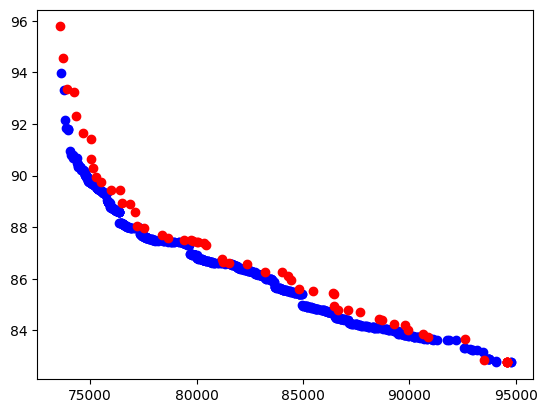

In [13]:
import math
import dill
dill.load_session(f"RunsV4/RUN0_BASELINE.pkl")
MinOASPL = math.inf
MinPower = math.inf
for individual in optimization_NSGA2.return_pareto_front(OptimizationObject.current_pop):
    funcs = individual.get_ObjVal()
    if funcs[0] < MinPower:
        MinPower = funcs[0]
        MinPowerIndividual = individual
    if funcs[1] < MinOASPL:
        MinOASPL = funcs[1]
        MinOASPLIndividual = individual
    plt.plot(funcs[0], funcs[1], 'bo')
dill.load_session(f"RunsV4/RUN36_5.pkl")
MinOASPL = math.inf
MinPower = math.inf
for individual in optimization_NSGA2.return_pareto_front(OptimizationObject.current_pop):
    funcs = individual.get_ObjVal()
    if funcs[0] < MinPower:
        MinPower = funcs[0]
        MinPowerIndividual = individual
    if funcs[1] < MinOASPL:
        MinOASPL = funcs[1]
        MinOASPLIndividual = individual
    plt.plot(funcs[0], funcs[1], 'ro')
plt.show()